## Overview

This code trains an SVM model on the June 1st SP dataset and then predicts SP values for June 2nd. These predictions feed directly into the RHC-SP algorithm. For more details, see Appendix B. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import networkx as nx
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

june1_df_sp = pd.read_csv("..//Database//prediction//network_metrics_train.csv", index_col=0)
june2_df_sp = pd.read_csv("..//Database//prediction//network_metrics_test.csv", index_col=0)
# why consider not full network?
june1_df_sp_hr_nt = june1_df_sp[june1_df_sp['full_network']==True]
june2_df_sp_hr_nt = june2_df_sp[june2_df_sp['full_network']==True]

t_buffer = 15 # buffer time in minutes

In [4]:
order = pd.read_csv("..//Database//NYC_trip//order_clean_260.csv", index_col=0)
order["call_time"] = pd.to_datetime(order["call_time"])
order["end_time"] = pd.to_datetime(order["end_time"])
start_time = pd.to_datetime("2022-06-01 08:00:00 AM")
end_time = pd.to_datetime("2022-06-01 10:00:00 AM")
june1 = order[(order["call_time"] > start_time) & (order["call_time"] <= end_time)]

start_time = pd.to_datetime("2022-06-02 08:00:00 AM")
end_time = pd.to_datetime("2022-06-02 10:00:00 AM")
june2 = order[(order["call_time"] > start_time) & (order["call_time"] <= end_time)]

In [5]:
june1_df_sp_hr_nt.reset_index(drop=True, inplace=True)
june1.reset_index(drop=True, inplace=True)
june2_df_sp_hr_nt.reset_index(drop=True, inplace=True)
june2.reset_index(drop=True, inplace=True)
train = pd.concat([june1_df_sp_hr_nt, june1], axis=1)
test = pd.concat([june2_df_sp_hr_nt, june2], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11483 entries, 0 to 11482
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   degree                  11483 non-null  int64         
 1   in_degree               11483 non-null  int64         
 2   out_degree              11483 non-null  int64         
 3   betweenness_centrality  11483 non-null  float64       
 4   closeness_centrality    11483 non-null  float64       
 5   katz_centrality         11483 non-null  float64       
 6   time                    11483 non-null  object        
 7   SP                      11483 non-null  int64         
 8   full_network            11483 non-null  bool          
 9   sid                     11483 non-null  int64         
 10  call_time               11483 non-null  datetime64[ns]
 11  eid                     11483 non-null  int64         
 12  end_time                11483 non-null  dateti

In [6]:
train = train[train['end_time'] != train['end_time'].max()]
test['end_time'].max(), train['end_time'].max()

(Timestamp('2022-06-02 11:14:59'), Timestamp('2022-06-01 11:16:13'))

In [7]:
train = train[train['SP'] != 1]
test = test[test['SP'] != 1]
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10043 entries, 0 to 11824
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   degree                  10043 non-null  int64         
 1   in_degree               10043 non-null  int64         
 2   out_degree              10043 non-null  int64         
 3   betweenness_centrality  10043 non-null  float64       
 4   closeness_centrality    10043 non-null  float64       
 5   katz_centrality         10043 non-null  float64       
 6   time                    10043 non-null  object        
 7   SP                      10043 non-null  int64         
 8   full_network            10043 non-null  bool          
 9   sid                     10043 non-null  int64         
 10  call_time               10043 non-null  datetime64[ns]
 11  eid                     10043 non-null  int64         
 12  end_time                10043 non-null  datetime64[

In [8]:
train['time_to_sink'] =((11 - train['end_time'].dt.hour)*60 + t_buffer - train['end_time'].dt.minute)
test['time_to_sink'] = ((11 - test['end_time'].dt.hour)*60 + t_buffer - test['end_time'].dt.minute)
train['SP_over_time'] = train['SP'] / ((11 - train['end_time'].dt.hour)*60 + t_buffer - train['end_time'].dt.minute)
test['SP_over_time'] = test['SP'] / ((11 - test['end_time'].dt.hour)*60 + t_buffer - test['end_time'].dt.minute)

In [9]:
ns_metrics = train.columns[:6].tolist() 
order_val = train.columns[9:15].tolist()
call_and_delta =  [train.columns[10]] + [train.columns[13]]
input_feature = ns_metrics + order_val[:-2]
input_feature_order = input_feature[6:]
print(input_feature_order)

['sid', 'call_time', 'eid', 'end_time']


In [10]:
X_train = train[input_feature_order]
X_train['call_time'] = (X_train['call_time'].dt.hour -8)*60 + X_train['call_time'].dt.minute
X_train['end_time'] = (X_train['end_time'].dt.hour -8)*60 + X_train['end_time'].dt.minute
y_train = train['SP_over_time'].to_list()
y_train = np.array(y_train).reshape(-1, 1)
X_train = X_train.values

X_test = test[input_feature_order]
X_test['call_time'] = (X_test['call_time'].dt.hour -8)*60 + X_test['call_time'].dt.minute
X_test['end_time'] = (X_test['end_time'].dt.hour -8)*60 + X_test['end_time'].dt.minute
y_test = test['SP_over_time'].to_list()
y_test = np.array(y_test).reshape(-1, 1)
X_test = X_test.values

C:\Users\RTW\AppData\Local\Temp\ipykernel_32456\3637783712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['call_time'] = (X_train['call_time'].dt.hour -8)*60 + X_train['call_time'].dt.minute
C:\Users\RTW\AppData\Local\Temp\ipykernel_32456\3637783712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['end_time'] = (X_train['end_time'].dt.hour -8)*60 + X_train['end_time'].dt.minute
C:\Users\RTW\AppData\Local\Temp\ipykernel_32456\3637783712.py:9: SettingWithCopyWarning: 
A value is trying

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor

In [12]:
reg = linear_model.LinearRegression()

# Split the data into training/testing sets
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

X_train_scaled = X_scaled[:len(X_train)]
y_train_scaled = y_scaled[:len(y_train)]
X_test_scaled = X_scaled[len(X_train):]
y_test_scaled = y_scaled[len(y_train):]

# SVM

In [13]:
clf = svm.SVR(kernel = 'rbf')
scores = cross_val_score(clf, X_train_scaled, y_train_scaled, cv=5)
scores.mean()

c:\Users\RTW\miniconda3\envs\network\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\RTW\miniconda3\envs\network\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\RTW\miniconda3\envs\network\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\RTW\miniconda3\envs\network\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\RTW\miniconda3\envs\network\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expec

np.float64(0.9605281276461722)

In [14]:
from sklearn.model_selection import GridSearchCV

# for demonstration purpose, we only consider 2 hyperparameters
param_grid = {'C': [300], 'gamma': [0.001, 0.01], 'kernel': ['rbf'], 'epsilon': [0.01, 0.05, 0.1]}
base_estimator = svm.SVR()

clf = GridSearchCV(base_estimator, param_grid, cv=5, n_jobs = -1, verbose = 2)
clf.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\RTW\miniconda3\envs\network\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,estimator,SVR()
,param_grid,"{'C': [300], 'epsilon': [0.01, 0.05, ...], 'gamma': [0.001, 0.01], 'kernel': ['rbf']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,kernel,'rbf'


In [15]:
print(clf.best_params_) 
print(clf.best_estimator_) 

{'C': 300, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
SVR(C=300, gamma=0.01)


In [16]:
clf_best = svm.SVR(C=300, gamma=0.01, kernel='rbf', epsilon=0.1)

clf_best.fit(X_train_scaled, y_train_scaled)
y_pre = clf_best.predict(X_test_scaled)
y_pre_true = scaler.inverse_transform(y_pre.reshape(-1, 1))

y_pre_train = clf_best.predict(X_train_scaled)
y_pre_train_true = scaler.inverse_transform(y_pre_train.reshape(-1, 1))

r2_score(y_test_scaled, y_pre), r2_score(y_test, y_pre_true), r2_score(y_train_scaled, y_pre_train), r2_score(y_train, y_pre_train_true)

c:\Users\RTW\miniconda3\envs\network\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9533033976441134,
 0.9533033976441134,
 0.9641085760833178,
 0.9641085760833179)

In [18]:
SP_recovered =(y_pre_true.ravel() * test['time_to_sink'].to_list()).round().flatten()
test["SP_recovered"] = SP_recovered
test = test.rename(columns={'SP': "SP_true", 'SP_over_time': "TSSP"})
june2_pred = june2_df_sp_hr_nt.join(test[["SP_recovered", "SP_true"]])
june2_pred.fillna(1, inplace=True)
june2_pred.SP_true = june2_pred.SP_true.astype(int)
assert (june2_pred.SP_true - june2_pred.SP).sum() == 0

## Plot results - Figure 6

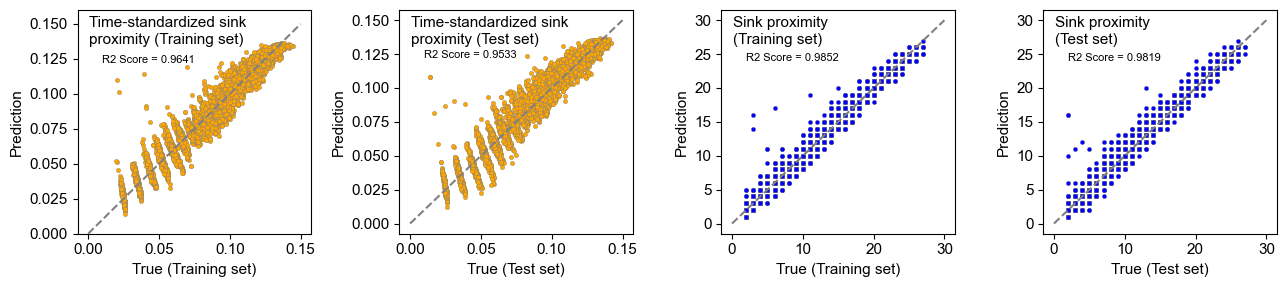

In [19]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 11


# plot training set and test set
df0 = pd.DataFrame({'y_test': y_test.flatten(), 'y_pre': y_pre_true.flatten()})
df0_train = pd.DataFrame({'y_train': y_train.flatten(), 'y_pre': y_pre_train_true.flatten()})
df1 = pd.DataFrame({'y_test': test['SP_true'], 'y_pre': (y_pre_true.ravel() * test['time_to_sink'].to_list()).round().flatten()})
df1_train = pd.DataFrame({'y_train': train['SP'], 'y_pre': (y_pre_train_true.ravel() * train['time_to_sink'].to_list()).round().flatten()})

r2_s1 = r2_score(y_test, y_pre_true)
r2_s2 = r2_score(test['SP_true'], (y_pre_true.ravel() * test['time_to_sink'].to_list()).round().flatten())
r2_s1_train = r2_score(y_train, y_pre_train_true)
r2_s2_train = r2_score(train['SP'], (y_pre_train_true.ravel() * train['time_to_sink'].to_list()).round().flatten())

fig, ax = plt.subplots(1, 4, figsize=(13, 3), tight_layout=True)
ax = ax.ravel()

sns.scatterplot(data=df0_train, x="y_train", y="y_pre",  color = 'orange', edgecolor='grey', label = "Time-standardized \n sink proximity", markers='o', s=10, ax= ax[0])

sns.scatterplot(data=df0, x="y_test", y="y_pre",  color = 'orange', edgecolor='grey', label = "Time-standardized \n sink proximity", markers='o', s=10, ax= ax[1])

sns.scatterplot(data=df1_train, x="y_train", y="y_pre",  color = 'blue', edgecolor='grey', label = "Sink proximity", markers='o', s=10, ax= ax[2])

sns.scatterplot(data=df1, x="y_test", y="y_pre",  color = 'blue', edgecolor='grey', label = "Sink proximity", markers='o', s=10, ax= ax[3])


sns.lineplot(x=[0, 0.15], y=[0, 0.15], color = 'grey', linestyle = '--', ax=ax[0])
sns.lineplot(x=[0, 0.15], y=[0, 0.15], color = 'grey', linestyle = '--', ax=ax[1])
sns.lineplot(x=[0, 30], y=[0, 30], color = 'grey', linestyle = '--', ax=ax[2])
sns.lineplot(x=[0, 30], y=[0, 30], color = 'grey', linestyle = '--', ax=ax[3])

ax[0].set_xlabel('True (Training set)')
ax[0].set_ylabel('Prediction')
ax[1].set_xlabel('True (Test set)')
ax[1].set_ylabel('Prediction')
ax[2].set_xlabel('True (Training set)')
ax[2].set_ylabel('Prediction')
ax[3].set_xlabel('True (Test set)')
ax[3].set_ylabel('Prediction')
ax[0].set_ylim(0, 0.16)

ax[0].legend().remove()
ax[1].legend().remove()
ax[2].legend().remove()
ax[3].legend().remove()

# ax[0].set_title('(a) Time-standardized sink\nproximity (Training set)', fontsize=12, loc='left')
# ax[1].set_title('(b) Time-standardized sink\nproximity (Test set)', fontsize=12, loc='left')
# ax[2].set_title('(c) Sink proximity (Training set)', fontsize=12, loc='left')
# ax[3].set_title('(d) Sink proximity (Test set)', fontsize=12, loc='left')

ax[0].text(0.05, 0.85, 'Time-standardized sink\nproximity (Training set)', transform=ax[0].transAxes, fontsize=11)
ax[1].text(0.05, 0.85, 'Time-standardized sink\nproximity (Test set)', transform=ax[1].transAxes, fontsize=11)
ax[2].text(0.05, 0.85, 'Sink proximity\n(Training set)', transform=ax[2].transAxes, fontsize=11)
ax[3].text(0.05, 0.85, 'Sink proximity\n(Test set)', transform=ax[3].transAxes, fontsize=11)

ax[0].annotate('R2 Score = %0.4f'%r2_s1_train, xy=(0.01, 0.122), xytext=(0.01, 0.122), fontsize=8)
ax[1].annotate('R2 Score = %0.4f'%r2_s1, xy=(0.01, 0.122), xytext=(0.01, 0.122), fontsize=8)
ax[2].annotate('R2 Score = %0.4f'%r2_s2_train, xy=(2,24), xytext=(2,24), fontsize=8)
ax[3].annotate('R2 Score = %0.4f'%r2_s2, xy=(2,24), xytext=(2,24), fontsize=8)

plt.savefig("..//Database//prediction//svm_sink_proximity_prediction.png", dpi=300)
